In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
import pandas as pd


# Single Molecule Time Traces

In [2]:
from src.simulate_ctmc import simulate_protocol


In [3]:
experiment_setup = {
    "protocol": "Blinking",
    "experiment_duration": None,  # s
    "num_frames": 200,           # frames
    "frame_length": 1e-2,         # s
    "excitation_P": 5,            # W/cm^2
    "activation_rate": 1e-6,      # W/cm^2
    "excitation_wavelength": 647  # nm
}

# Default values for the molecule parameters dictionary
molecule = {
    "epsilon": 239000,                          # Extinction coefficient M^-1 cm^-1
    "excitation_lifetime": 1e-9,                # Excited state lifetime, s (1 ns)
    "num_cycles_before_bleaching": 1e3,          # Number of cycles before bleaching
    "alpha_nr": 1,                           # Proportional to Quantum yield
    "d_E": 0.5,                                 # Energy difference (eV)
    "alpha_isc": 1e-3                          # Intersystem crossing rate
}


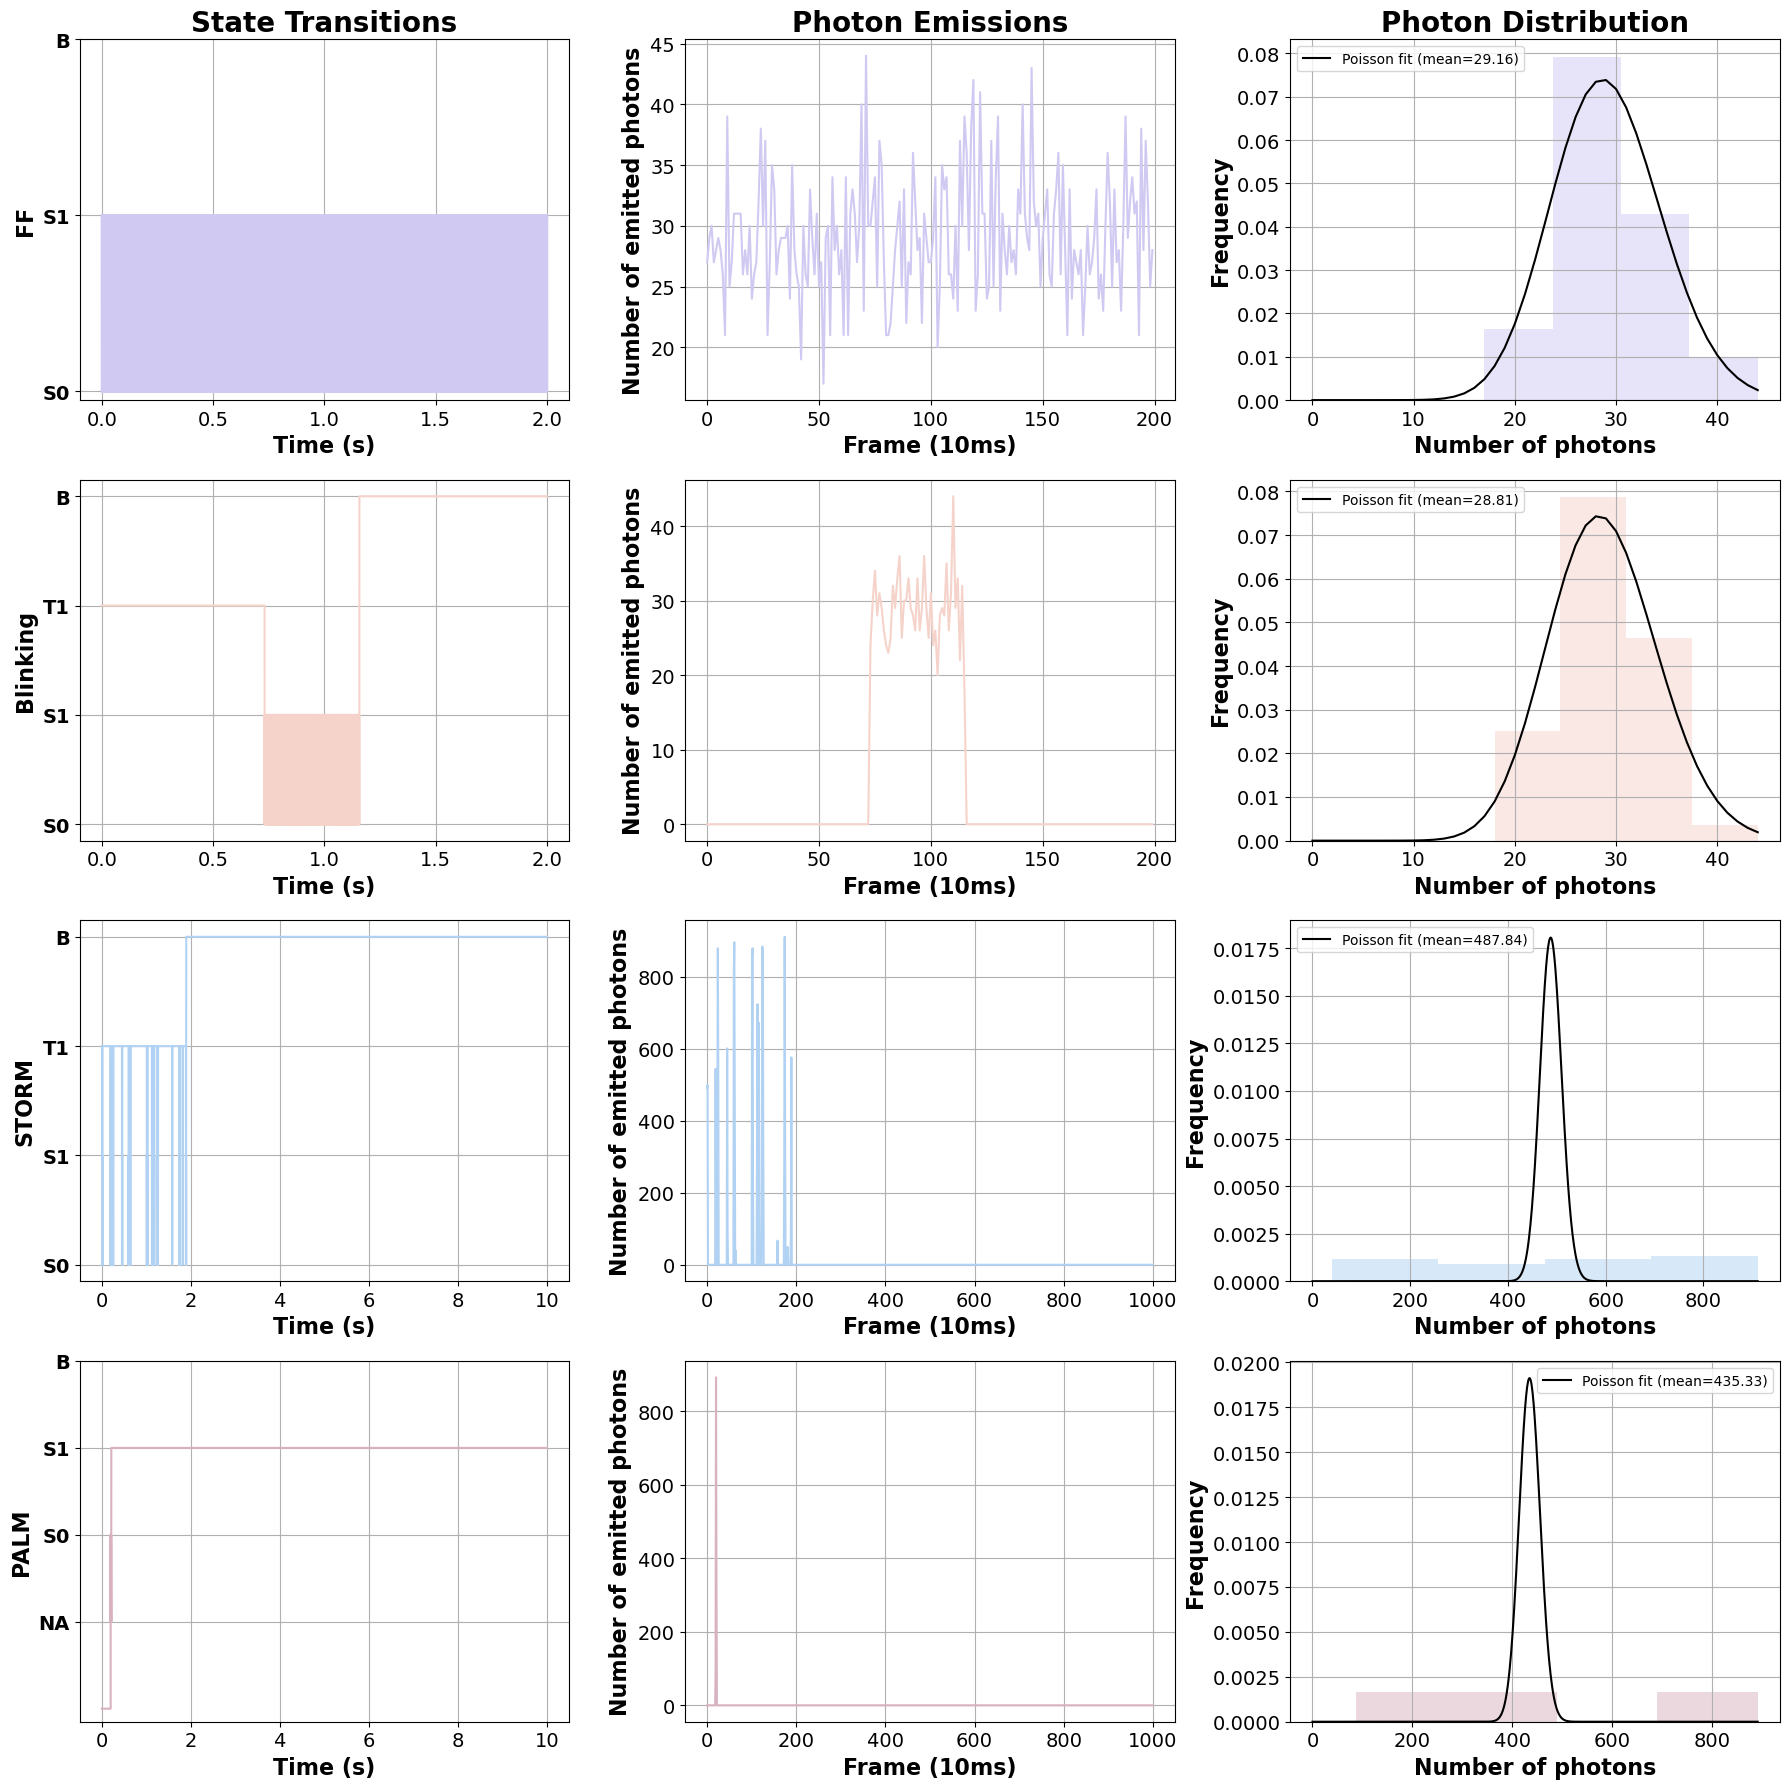

In [11]:
np.random.seed(1223)

protocol_colors = {
    "FF": "#d0c9f2",
    "Blinking": "#f5d3ca",
    "STORM": "#b1d2f3",
    "PALM": "#d8b2c1",
}

protocols = ["FF", "Blinking", "STORM", "PALM"]
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))

for i, protocol in enumerate(protocols):

    experiment_setup["protocol"] = protocol

    if protocol in ["PALM", "STORM"]:
        experiment_setup['activation_rate'] = 1e0
        experiment_setup["excitation_P"] = 30
        experiment_setup["num_frames"] = 1000
        if protocol == "PALM":
            molecule["num_cycles_before_bleaching"] = 5e3
        else:
            molecule["num_cycles_before_bleaching"] = 2e4

    if protocol == "STORM":
        molecule["alpha_isc"] = 5e-4
        molecule["alpha_nr"] = 10

    elif protocol == "FF":
        experiment_setup["excitation_P"] = 1
        experiment_setup["num_frames"] = 200
        molecule["num_cycles_before_bleaching"] = 5e3


    elif protocol == "Blinking":
        experiment_setup["excitation_P"] = 1
        experiment_setup["num_frames"] = 200
        molecule["num_cycles_before_bleaching"] = 1e3
        molecule["alpha_isc"] = 1e-3
        molecule["alpha_nr"] = 3

    experiment_setup["experiment_duration"] = experiment_setup["num_frames"] * experiment_setup["frame_length"]

    times, dynamics, Q, photons = simulate_protocol(experiment_setup, molecule)

    color = protocol_colors[protocol]



    label_fontsize = 16
    tick_fontsize = 14
    title_fontsize = 20

    ax1 = axes[i, 0]
    ax1.step(times, dynamics, where="post", color=color)
    if i == 0:
        ax1.set_title("State Transitions", fontsize=title_fontsize, fontweight='bold')
    ax1.set_xlabel("Time (s)", fontsize=label_fontsize, fontweight='bold')
    ax1.set_ylabel(protocol, fontsize=label_fontsize, fontweight='bold')  
    ax1.tick_params(axis='both', labelsize=tick_fontsize)
    ax1.grid(True)

    if protocol == "FF":
        ax1.set_yticks([0, 1, 2])
        ax1.set_yticklabels(["S0", "S1", "B"], fontsize=tick_fontsize, fontweight='bold')
    elif protocol in ["Blinking", "STORM"]:
        ax1.set_yticks([0, 1, 2, 3])
        ax1.set_yticklabels(["S0", "S1", "T1", "B"], fontsize=tick_fontsize, fontweight='bold')
    elif protocol == "PALM":
        ax1.set_yticks([0, 1, 2, 3])
        ax1.set_yticklabels(["NA", "S0", "S1", "B"], fontsize=tick_fontsize, fontweight='bold')

    ax2 = axes[i, 1]
    ax2.plot(np.arange(experiment_setup["num_frames"]), photons, color=color)
    if i == 0:
        ax2.set_title("Photon Emissions", fontsize=title_fontsize, fontweight='bold')
    ax2.set_xlabel("Frame (10ms)", fontsize=label_fontsize, fontweight='bold')
    ax2.set_ylabel("Number of emitted photons", fontsize=label_fontsize, fontweight='bold')
    ax2.tick_params(axis='both', labelsize=tick_fontsize)
    ax2.grid(True)

    ax3 = axes[i, 2]
    ax3.hist(photons[photons != 0], bins=4, density=True, alpha=0.5, color=color)

    mean_photons = np.mean(photons[photons != 0])
    x = np.arange(0, int(np.max(photons)) + 1)
    pmf = poisson.pmf(x, mu=mean_photons)
    ax3.plot(x, pmf, 'k-', lw=1.5, label=f'Poisson fit (mean={mean_photons:.2f})')
    ax3.legend()

    if i == 0:
        ax3.set_title("Photon Distribution", fontsize=title_fontsize, fontweight='bold')
    ax3.set_xlabel("Number of photons", fontsize=label_fontsize, fontweight='bold')
    ax3.set_ylabel("Frequency", fontsize=label_fontsize, fontweight='bold')
    ax3.tick_params(axis='both', labelsize=tick_fontsize)
    ax3.grid(True)



plt.tight_layout()
# plt.savefig("four_protocols_with_states.svg", format="svg", bbox_inches='tight', pad_inches=0)
plt.show()


# Simulate a Structure

In [2]:
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm

In [13]:
from src.simulate_ctmc import simulate_protocol
from src.camera import apply_camera_advanced


# Define the function to simulate one sample
def simulate_sample(experiment_setup, molecule):
    _,_,Q,photons = simulate_protocol(experiment_setup, molecule)
    return photons


## 1. Import and Define the structure

In [90]:
def import_positions_array(file_name, min_x, max_x, min_y, max_y, out_grid_shape):
    """
    Imports fluorophore positions from a CSV file, filters based on custom bounds,
    and places the fluorophores on a grid of a specified shape.

    Args:
    - file_name (str): Path to the CSV file containing the positions.
    - min_x (int): Minimum x-coordinate for filtering fluorophores.
    - max_x (int): Maximum x-coordinate for filtering fluorophores.
    - min_y (int): Minimum y-coordinate for filtering fluorophores.
    - max_y (int): Maximum y-coordinate for filtering fluorophores.
    - out_grid_shape (tuple): Shape of the output grid (height, width).

    Returns:
    - grid (np.array): A 2D array of the specified shape with fluorophore counts.
    - num_fluorophores (int): The number of fluorophores within the specified bounds.
    - filtered_x (pd.Series): The filtered x-coordinates after bounding and rescaling.
    - filtered_y (pd.Series): The filtered y-coordinates after bounding and rescaling.
    """
    df = pd.read_csv(file_name, header=None)
    df.columns = ['x', 'y', 'z']

    # Apply the filtering based on input x and y bounds
    x, y = df['x'], df['y']
    filtered_positions = df[(x >= min_x) & (x <= max_x) & (y >= min_y) & (y <= max_y)]

    # Rescale the positions to fit into the grid
    filtered_x = ((filtered_positions['x'] - min_x) / (max_x - min_x) * (out_grid_shape[1] - 1)).astype(int)[::6]
    filtered_y = ((filtered_positions['y'] - min_y) / (max_y - min_y) * (out_grid_shape[0] - 1)).astype(int)[::6]

    # Initialize the grid with the specified shape
    grid = np.zeros(out_grid_shape, dtype=int)

    # Add fluorophores to the grid
    np.add.at(grid, (filtered_y, filtered_x), 1)

    # Count the number of fluorophores
    num_fluorophores = filtered_x.shape[0]

    return grid, num_fluorophores, filtered_x, filtered_y



In [91]:

file_path= "examples/position.csv"

grid, num_fluorophores, filtered_x, filtered_y = import_positions_array(file_path, 1500, 3000, 1500, 3000, (1024,1024))
print('grid= ', grid[grid==1].shape)

print("num_fluorophores = ", num_fluorophores)



grid=  (1063,)
num_fluorophores =  1083


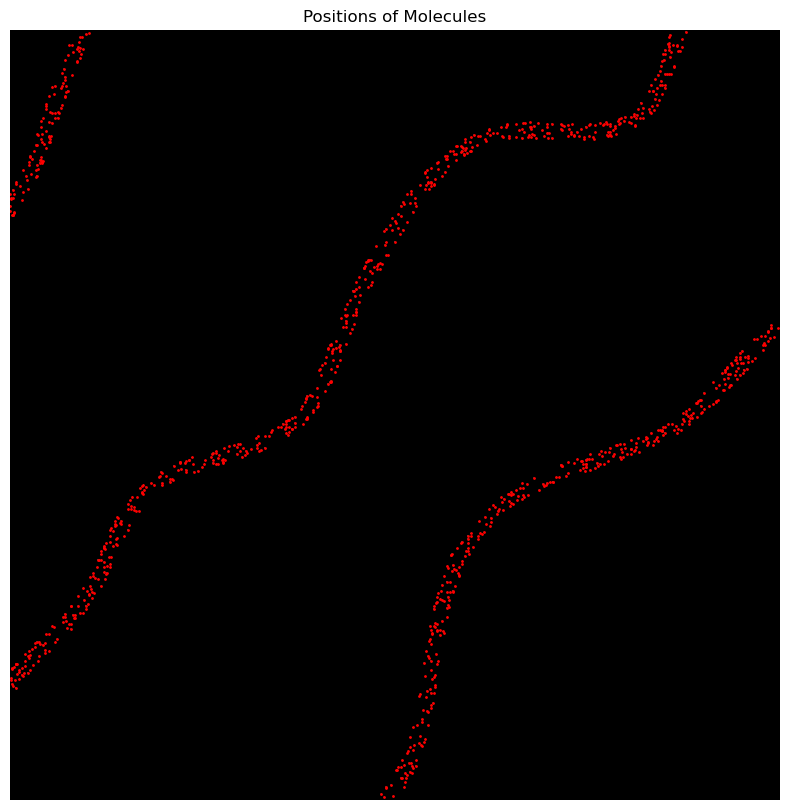

In [92]:
grid_to_plot = grid[:100,:100]
filtered_x_to_plot = filtered_x.to_numpy()[800:1000]
filtered_y_to_plot = filtered_y.to_numpy()[800:1000]
grid_size = grid.shape  # (height, width)


plt.figure(figsize=(10, 10)) 
plt.imshow(grid,cmap="gray")
plt.scatter(filtered_x, filtered_y, s=1, c='red', marker='o')  
plt.axis('off')
plt.grid(False)
plt.title("Positions of Molecules")
plt.show()

## 2. FF

In [28]:
experiment_setup = {
            "protocol": "FF",
            "experiment_duration": None,  # s
            "num_frames": 300,           # frames
            "frame_length": 1e-2,         # s
            "excitation_P": 2,            # W/cm^2
            "activation_rate": None,      # W/cm^2
            "excitation_wavelength": 488  # nm
        }
molecule = {
            "epsilon":  56000,                          # Extinction coefficient M^-1 cm^-1
            "excitation_lifetime": 2.6e-9,                # Excited state lifetime, s (1 ns)
            "num_cycles_before_bleaching": 5e3,         # Number of cycles before bleaching
            "alpha_nr": None,                           # Proportional to Quantum yield
            "d_E": None,                                 # Energy difference (eV)
            "alpha_isc": None                            # Intersystem crossing rate
        }


In [29]:

# Define your protocols
protocol = experiment_setup["protocol"]

experiment_setup["experiment_duration"] = experiment_setup["num_frames"] * experiment_setup["frame_length"]

# Run the simulations in parallel
results = Parallel(n_jobs=-1)(
    delayed(simulate_sample)(experiment_setup, molecule)
    for _ in tqdm(range(num_fluorophores), desc=f"Simulating {protocol}")
)

# # Save results using protocol name
# results_by_protocol[protocol] = results

# Save all results to a file
with open(f"examples/time_traces/FFresults_by_{protocol}.pkl", "wb") as f:
    pickle.dump(results, f)


Simulating FF: 100%|██████████| 1083/1083 [00:07<00:00, 153.56it/s]


In [ ]:
print(results.shape)
# Convert filtered_x and filtered_y to proper NumPy arrays
filtered_x_ = filtered_x.to_numpy().flatten().astype(int)
filtered_y_ = filtered_y.to_numpy().flatten().astype(int)

num_fluorophores = results.shape[0]

filtered_x_sampled = filtered_x_[:num_fluorophores]
filtered_y_sampled = filtered_y_[:num_fluorophores]



# Ensure indices are within bounds
filtered_y_sampled = np.clip(filtered_y_sampled, 0, grid_size[1] - 1)
filtered_y_sampled = np.clip(filtered_y_sampled, 0, grid_size[0] - 1)



# Check for any mismatches
assert len(filtered_x) == num_fluorophores, "Mismatch: filtered_x length does not match num_fluorophores"
assert len(filtered_y) == num_fluorophores, "Mismatch: filtered_y length does not match num_fluorophores"



(1083, 300)


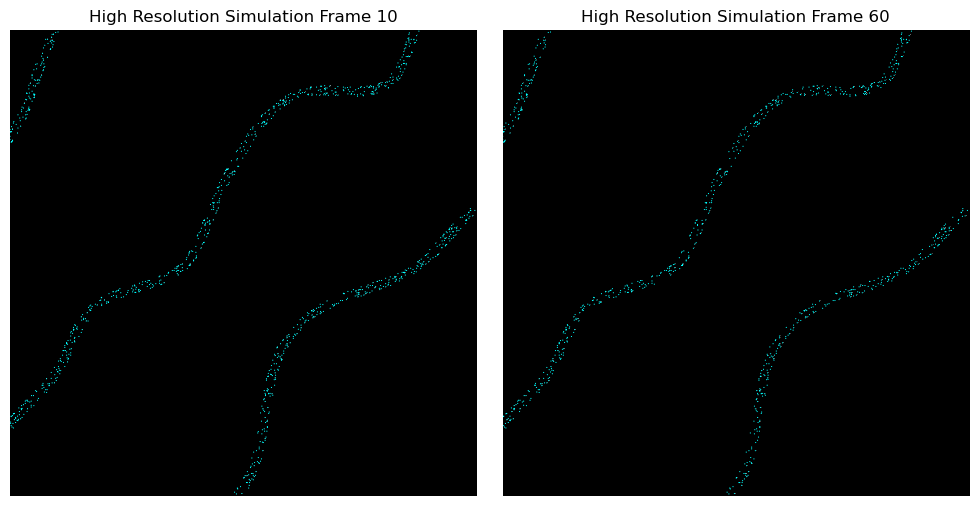

In [ ]:


num_frames=experiment_setup["num_frames"]
frames = np.zeros((num_frames, *grid_size))

results = np.array(results)  




# Assign values for each molecule at its respective grid position
for i in range(num_fluorophores):
    x, y = filtered_x_sampled[i], filtered_y_sampled[i]
    frames[:, y, x] += results[i]  # Assign molecule intensities

# Animate the frames

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Frame 10
frame10 = frames[10]
ax1.imshow(frame10, cmap='gray', interpolation='nearest', vmin=0, vmax=40)
ax1.contour(frame10 > 0, colors='cyan', linewidths=0.5)  # outline where signal exists
ax1.set_title('High Resolution Simulation Frame 10')
ax1.axis('off')

# Frame 90
frame90 = frames[90]
ax2.imshow(frame90, cmap='gray', interpolation='nearest', vmin=0, vmax=40)
ax2.contour(frame90 > 0, colors='cyan', linewidths=0.5)
ax2.set_title('High Resolution Simulation Frame 60')
ax2.axis('off')

plt.tight_layout()
plt.show()


In [79]:

num_frames = frames.shape[0]

blurred_stack = []
adu_stack = []

for i in range(num_frames):
    blurred, frame_adu = apply_camera_advanced(
        frames[i],
        QE=0.9,
        sigma_R=74.4,
        c=0.002,
        EM_gain=300,
        e_adu=45,
        BL=100,
        us_factor=4,
        kwidth=91,
        FWHM=450,
        px=103,
        background=2,
        camera_type="EMCCD",
        ADC_max=65535
    )

    blurred_stack.append(blurred)
    adu_stack.append(frame_adu)

blurred_stack = np.stack(blurred_stack)  # (300, H, W) blurred, still high-res
adu_stack = np.stack(adu_stack)          # (300, H', W') low-res, digitized frames


/home/wessim/MUFASA_Fluorescence_Fluctuations_Simulation/src/camera.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  blurred_tensor = torch.tensor(blurred[None, None], dtype=torch.float32)


In [81]:
np.save(f'examples/time_traces/{protocol}/blurred_stack.npy', blurred_stack)
np.save(f'examples/time_traces/{protocol}/adu_stack.npy', adu_stack)

In [109]:
blurred_stack = np.load(f'examples/time_traces/FF/blurred_stack.npy')
adu_stack = np.load(f'examples/time_traces/FF/adu_stack.npy')

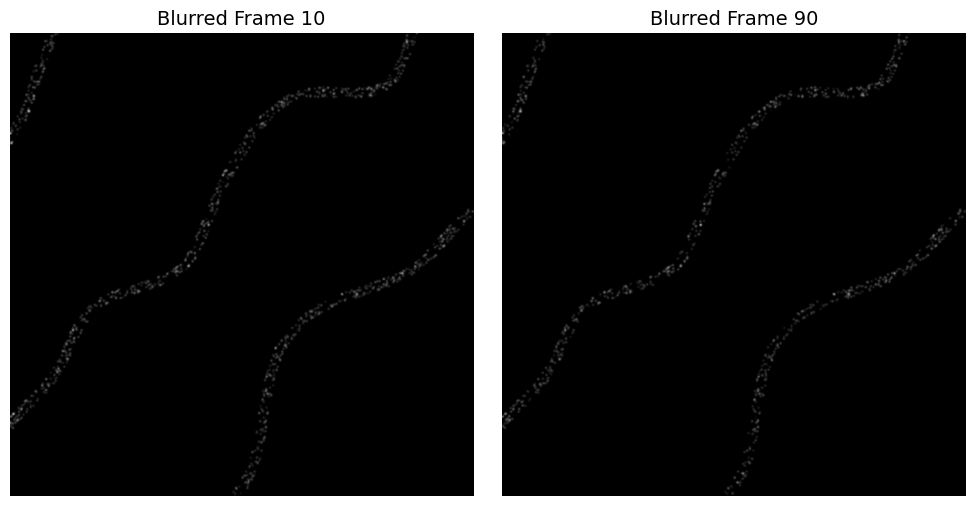

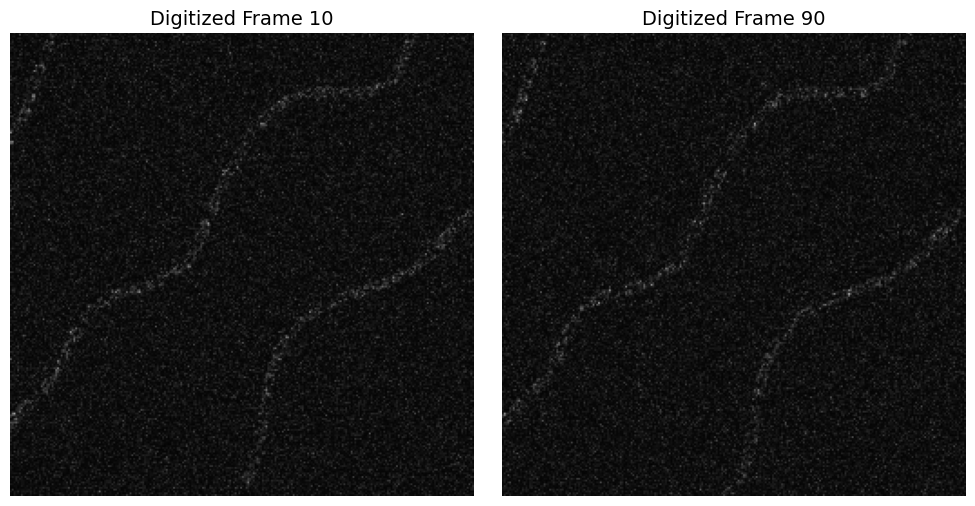

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Auto contrast limits
vmin = blurred_stack.min()
vmax =blurred_stack.max()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))



# Display the noisy frame
ax1.imshow(blurred_stack[10], cmap="gray", vmin=vmin, vmax=vmax)
ax1.set_title('Blurred Frame 10', fontsize=14)
ax1.axis('off')

# Display frame 90 without extra noise
ax2.imshow(blurred_stack[90], cmap="gray", vmin=vmin, vmax=vmax)
ax2.set_title('Blurred Frame 90', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()


vmin = adu_stack.min()
vmax = adu_stack.max()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))



# Display the noisy frame
ax1.imshow(adu_stack[10], cmap="gray", vmin=vmin, vmax=vmax)
ax1.set_title('Digitized Frame 10', fontsize=14)
ax1.axis('off')

# Display frame 90 without extra noise
ax2.imshow(adu_stack[60], cmap="gray", vmin=vmin, vmax=vmax)
ax2.set_title('Digitized Frame 90', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()



## 3. STORM

In [215]:
experiment_setup = {
            "protocol": "STORM",
            "experiment_duration": None,  # s
            "num_frames": 300,           # frames
            "frame_length": 1e-2,         # s
            "excitation_P": 70,            # W/cm^2
            "activation_rate": None,      # W/cm^2
            "excitation_wavelength": 488  # nm
        }
molecule = {
            "epsilon":  56000,                          # Extinction coefficient M^-1 cm^-1
            "excitation_lifetime": 2.6e-9,                # Excited state lifetime, s (1 ns)
            "num_cycles_before_bleaching": 5e5,         # Number of cycles before bleaching
            "alpha_nr": 2,                           # Proportional to Quantum yield
            "d_E": 0.5,                                 # Energy difference (eV)
            "alpha_isc": 5e-4                            # Intersystem crossing rate
        }


In [216]:

# Define your protocols
protocol = experiment_setup["protocol"]

experiment_setup["experiment_duration"] = experiment_setup["num_frames"] * experiment_setup["frame_length"]

# Run the simulations in parallel
results = Parallel(n_jobs=-1)(
    delayed(simulate_sample)(experiment_setup, molecule)
    for _ in tqdm(range(num_fluorophores), desc=f"Simulating {protocol}")
)

# # Save results using protocol name
# results_by_protocol[protocol] = results

# Save all results to a file
with open(f"examples/time_traces/{protocol}/results_by_{protocol}.pkl", "wb") as f:
    pickle.dump(results, f)

Simulating STORM: 100%|██████████| 1083/1083 [00:32<00:00, 33.72it/s]


In [217]:
print(len(results))
# Convert filtered_x and filtered_y to proper NumPy arrays
filtered_x_ = filtered_x.to_numpy().flatten().astype(int)
filtered_y_ = filtered_y.to_numpy().flatten().astype(int)

num_fluorophores = len(results)

filtered_x_sampled = filtered_x_[:num_fluorophores]
filtered_y_sampled = filtered_y_[:num_fluorophores]



# Ensure indices are within bounds
filtered_y_sampled = np.clip(filtered_y_sampled, 0, grid_size[1] - 1)
filtered_y_sampled = np.clip(filtered_y_sampled, 0, grid_size[0] - 1)



# Check for any mismatches
assert len(filtered_x) == num_fluorophores, "Mismatch: filtered_x length does not match num_fluorophores"
assert len(filtered_y) == num_fluorophores, "Mismatch: filtered_y length does not match num_fluorophores"



1083


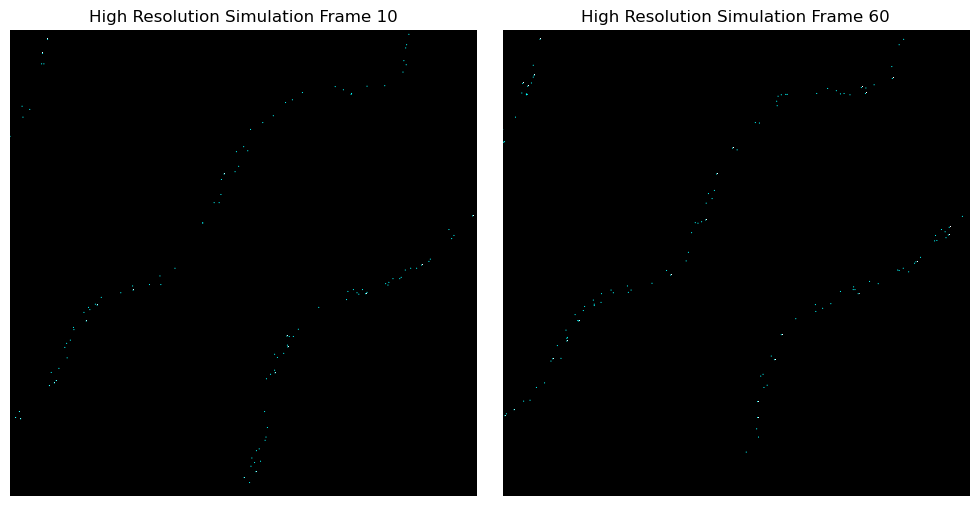

In [218]:

num_frames=experiment_setup["num_frames"]

frames = np.zeros((num_frames, *grid_size))

# Convert results to NumPy array
results = np.array(results)  # Ensure correct shape (num_fluorophores, num_frames)




# Assign values for each molecule at its respective grid position
for i in range(num_fluorophores):
    x, y = filtered_x_sampled[i], filtered_y_sampled[i]
    frames[:, y, x] += results[i]  # Assign molecule intensities

# Animate the frames

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Frame 10
frame10 = frames[10]
ax1.imshow(frame10, cmap='gray', interpolation='nearest', vmin=0, vmax=40)
ax1.contour(frame10 > 0, colors='cyan', linewidths=0.5)  # outline where signal exists
ax1.set_title('High Resolution Simulation Frame 10')
ax1.axis('off')

# Frame 90
frame90 = frames[90]
ax2.imshow(frame90, cmap='gray', interpolation='nearest', vmin=0, vmax=40)
ax2.contour(frame90 > 0, colors='cyan', linewidths=0.5)
ax2.set_title('High Resolution Simulation Frame 60')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [219]:

num_frames = frames.shape[0]

blurred_stack = []
adu_stack = []

for i in range(num_frames):
    blurred, frame_adu = apply_camera_advanced(
        frames[i],
        QE=0.9,
        sigma_R=10.4,
        c=0.002,
        EM_gain=300,
        e_adu=45,
        BL=100,
        us_factor=4,
        kwidth=91,
        FWHM=450,
        px=103,
        background=2,
        camera_type="CCD",
        ADC_max=65535
    )

    blurred_stack.append(blurred)
    adu_stack.append(frame_adu)

blurred_stack = np.stack(blurred_stack)  # (300, H, W) blurred, still high-res
adu_stack = np.stack(adu_stack)          # (300, H', W') low-res, digitized frames


In [115]:
np.save(f'examples/time_traces/{protocol}/blurred_stack.npy', blurred_stack)
np.save(f'examples/time_traces/{protocol}/adu_stack.npy', adu_stack)

In [ ]:
blurred_stack = np.load(f'examples/time_traces/{protocol}/blurred_stack.npy')
adu_stack = np.load(f'examples/time_traces/{protocol}/adu_stack.npy')

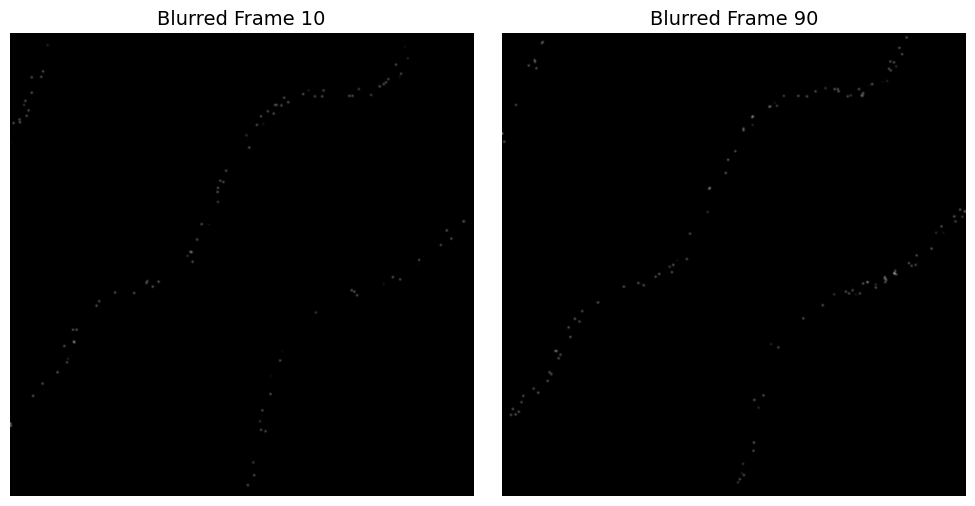

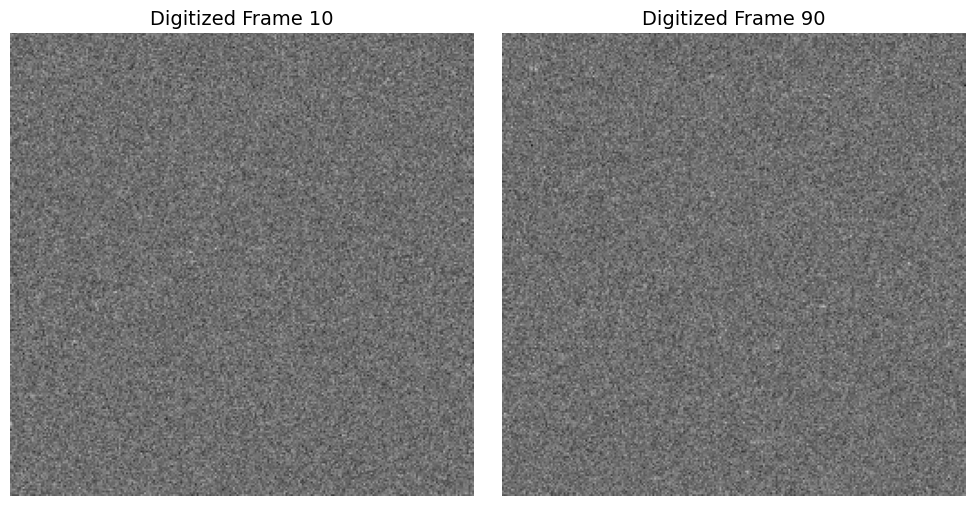

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Auto contrast limits
vmin = blurred_stack.min()
vmax =blurred_stack.max()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))



# Display the noisy frame
ax1.imshow(blurred_stack[10], cmap="gray", vmin=vmin, vmax=vmax)
ax1.set_title('Blurred Frame 10', fontsize=14)
ax1.axis('off')

# Display frame 90 without extra noise
ax2.imshow(blurred_stack[90], cmap="gray", vmin=vmin, vmax=vmax)
ax2.set_title('Blurred Frame 90', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()


vmin = adu_stack.min()
vmax = adu_stack.max()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))



# Display the noisy frame
ax1.imshow(adu_stack[10], cmap="gray", vmin=vmin, vmax=vmax)
ax1.set_title('Digitized Frame 10', fontsize=14)
ax1.axis('off')

# Display frame 90 without extra noise
ax2.imshow(adu_stack[60], cmap="gray", vmin=vmin, vmax=vmax)
ax2.set_title('Digitized Frame 90', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()



## 4. Blinking

In [165]:
experiment_setup = {
            "protocol": "Blinking",
            "experiment_duration": None,  # s
            "num_frames": 100,           # frames
            "frame_length": 1e-2,         # s
            "excitation_P": 2,            # W/cm^2
            "activation_rate": None,      # W/cm^2
            "excitation_wavelength": 488  # nm
        }
molecule = {
            "epsilon":  56000,                          # Extinction coefficient M^-1 cm^-1
            "excitation_lifetime": 2.6e-9,                # Excited state lifetime, s (1 ns)
            "num_cycles_before_bleaching":  1e3,         # Number of cycles before bleaching
            "alpha_nr":  3,                           # Proportional to Quantum yield
            "d_E": 0.5,                                 # Energy difference (eV)
            "alpha_isc": 5e-4                            # Intersystem crossing rate
        }


In [166]:

# Define your protocols
protocol = experiment_setup["protocol"]

experiment_setup["experiment_duration"] = experiment_setup["num_frames"] * experiment_setup["frame_length"]

# Run the simulations in parallel
results = Parallel(n_jobs=-1)(
    delayed(simulate_sample)(experiment_setup, molecule)
    for _ in tqdm(range(num_fluorophores), desc=f"Simulating {protocol}")
)

# # Save results using protocol name
# results_by_protocol[protocol] = results

# Save all results to a file
with open(f"examples/time_traces/{protocol}/results_by_{protocol}.pkl", "wb") as f:
    pickle.dump(results, f)

Simulating Blinking: 100%|██████████| 1083/1083 [00:03<00:00, 351.92it/s]


In [167]:
print(len(results))
# Convert filtered_x and filtered_y to proper NumPy arrays
filtered_x_ = filtered_x.to_numpy().flatten().astype(int)
filtered_y_ = filtered_y.to_numpy().flatten().astype(int)

num_fluorophores = len(results)

filtered_x_sampled = filtered_x_[:num_fluorophores]
filtered_y_sampled = filtered_y_[:num_fluorophores]



# Ensure indices are within bounds
filtered_y_sampled = np.clip(filtered_y_sampled, 0, grid_size[1] - 1)
filtered_y_sampled = np.clip(filtered_y_sampled, 0, grid_size[0] - 1)



# Check for any mismatches
assert len(filtered_x) == num_fluorophores, "Mismatch: filtered_x length does not match num_fluorophores"
assert len(filtered_y) == num_fluorophores, "Mismatch: filtered_y length does not match num_fluorophores"



1083


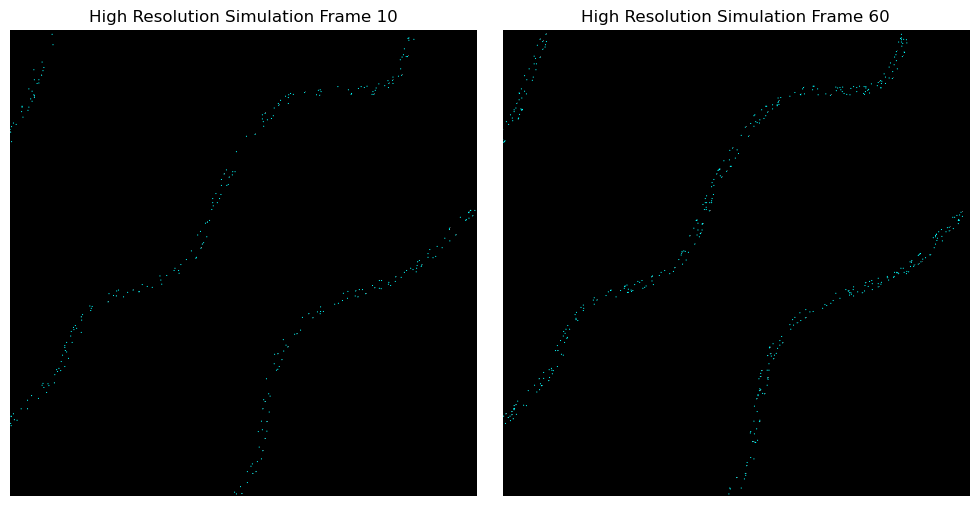

In [168]:

num_frames=experiment_setup["num_frames"]

frames = np.zeros((num_frames, *grid_size))

# Convert results to NumPy array
results = np.array(results)  # Ensure correct shape (num_fluorophores, num_frames)




# Assign values for each molecule at its respective grid position
for i in range(num_fluorophores):
    x, y = filtered_x_sampled[i], filtered_y_sampled[i]
    frames[:, y, x] += results[i]  # Assign molecule intensities

# Animate the frames

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Frame 10
frame10 = frames[10]
ax1.imshow(frame10, cmap='gray', interpolation='nearest', vmin=0, vmax=40)
ax1.contour(frame10 > 0, colors='cyan', linewidths=0.5)  # outline where signal exists
ax1.set_title('High Resolution Simulation Frame 10')
ax1.axis('off')

# Frame 90
frame90 = frames[90]
ax2.imshow(frame90, cmap='gray', interpolation='nearest', vmin=0, vmax=40)
ax2.contour(frame90 > 0, colors='cyan', linewidths=0.5)
ax2.set_title('High Resolution Simulation Frame 60')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [209]:

num_frames = frames.shape[0]

blurred_stack = []
adu_stack = []

def example_cmos_gain(electrons):
                gain = electrons
                return gain

for i in range(num_frames):
    blurred, frame_adu = apply_camera_advanced(
        frames[i],
        QE=0.9,
        sigma_R=74.4,
        c=0.002,
        EM_gain=300,
        e_adu=45,
        BL=100,
        us_factor=4,
        kwidth=91,
        FWHM=450,
        px=103,
        background=2,
        camera_type="EMCCD",
        ADC_max=65535,
        gp_cmos=example_cmos_gain
    )

    blurred_stack.append(blurred)
    adu_stack.append(frame_adu)

blurred_stack = np.stack(blurred_stack)  # (300, H, W) blurred, still high-res
adu_stack = np.stack(adu_stack)          # (300, H', W') low-res, digitized frames


/home/wessim/MUFASA_Fluorescence_Fluctuations_Simulation/src/camera.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  blurred_tensor = torch.tensor(blurred[None, None], dtype=torch.float32)


In [211]:
np.save(f'examples/time_traces/{protocol}/blurred_stack.npy', blurred_stack)
np.save(f'examples/time_traces/{protocol}/adu_stack.npy', adu_stack)

In [212]:
blurred_stack = np.load(f'examples/time_traces/Blinking/blurred_stack.npy')
adu_stack = np.load(f'examples/time_traces/Blinking/adu_stack.npy')

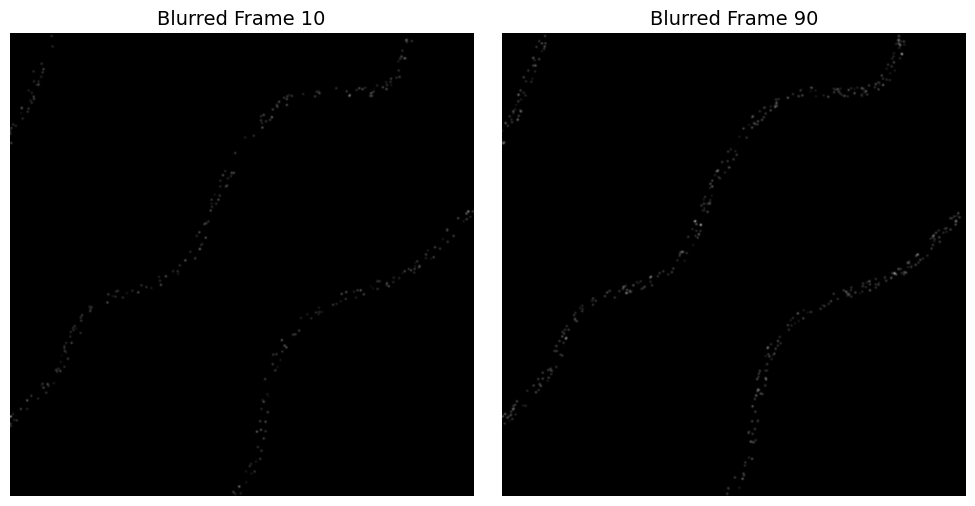

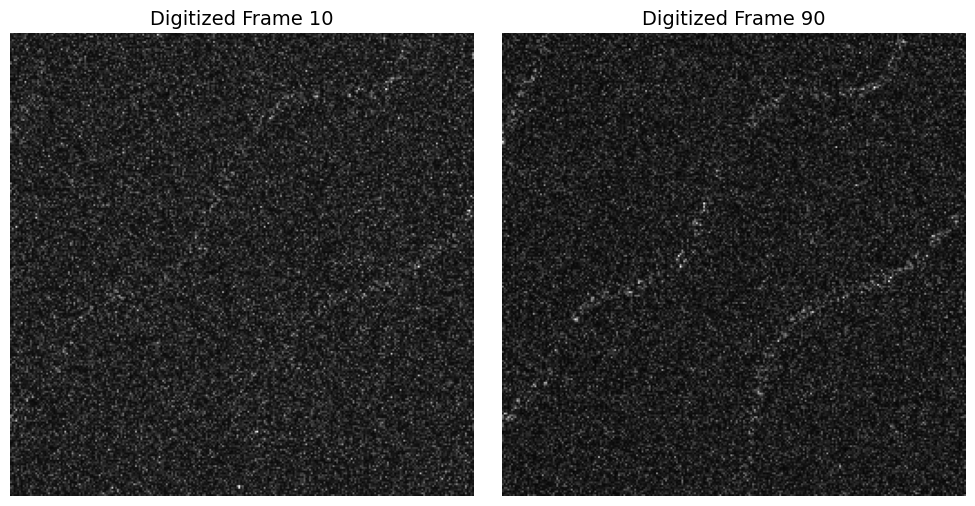

In [213]:
import matplotlib.pyplot as plt
import numpy as np

# Auto contrast limits
vmin = blurred_stack.min()
vmax =blurred_stack.max()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))



# Display the noisy frame
ax1.imshow(blurred_stack[10], cmap="gray", vmin=vmin, vmax=vmax)
ax1.set_title('Blurred Frame 10', fontsize=14)
ax1.axis('off')

# Display frame 90 without extra noise
ax2.imshow(blurred_stack[90], cmap="gray", vmin=vmin, vmax=vmax)
ax2.set_title('Blurred Frame 90', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()


vmin = adu_stack.min()
vmax = adu_stack.max()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))



# Display the noisy frame
ax1.imshow(adu_stack[10], cmap="gray")
ax1.set_title('Digitized Frame 10', fontsize=14)
ax1.axis('off')

# Display frame 90 without extra noise
ax2.imshow(adu_stack[60], cmap="gray")
ax2.set_title('Digitized Frame 90', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()



## 5. PALM

In [130]:
experiment_setup = {
            "protocol": "PALM",
            "experiment_duration": 1e0,  # s
            "num_frames": 300,           # frames
            "frame_length": 1e-2,         # s
            "excitation_P": 50,            # W/cm^2
            "activation_rate": 1e-1,      # W/cm^2
            "excitation_wavelength": 488  # nm
        }
molecule = {
            "epsilon":  56000,                          # Extinction coefficient M^-1 cm^-1
            "excitation_lifetime": 2.6e-9,                # Excited state lifetime, s (1 ns)
            "num_cycles_before_bleaching": 5e5,         # Number of cycles before bleaching
            "alpha_nr": 2,                           # Proportional to Quantum yield
            "d_E": 0.5,                                 # Energy difference (eV)
            "alpha_isc": 5e-4                            # Intersystem crossing rate
        }


In [131]:

# Define your protocols
protocol = experiment_setup["protocol"]

experiment_setup["experiment_duration"] = experiment_setup["num_frames"] * experiment_setup["frame_length"]

# Run the simulations in parallel
results = Parallel(n_jobs=-1)(
    delayed(simulate_sample)(experiment_setup, molecule)
    for _ in tqdm(range(num_fluorophores), desc=f"Simulating {protocol}")
)

# # Save results using protocol name
# results_by_protocol[protocol] = results

# Save all results to a file
with open(f"examples/time_traces/{protocol}/results_by_{protocol}.pkl", "wb") as f:
    pickle.dump(results, f)

Simulating PALM: 100%|██████████| 1083/1083 [00:28<00:00, 37.96it/s]


In [132]:
print(len(results))
# Convert filtered_x and filtered_y to proper NumPy arrays
filtered_x_ = filtered_x.to_numpy().flatten().astype(int)
filtered_y_ = filtered_y.to_numpy().flatten().astype(int)

num_fluorophores = len(results)

filtered_x_sampled = filtered_x_[:num_fluorophores]
filtered_y_sampled = filtered_y_[:num_fluorophores]



# Ensure indices are within bounds
filtered_y_sampled = np.clip(filtered_y_sampled, 0, grid_size[1] - 1)
filtered_y_sampled = np.clip(filtered_y_sampled, 0, grid_size[0] - 1)



# Check for any mismatches
assert len(filtered_x) == num_fluorophores, "Mismatch: filtered_x length does not match num_fluorophores"
assert len(filtered_y) == num_fluorophores, "Mismatch: filtered_y length does not match num_fluorophores"



1083


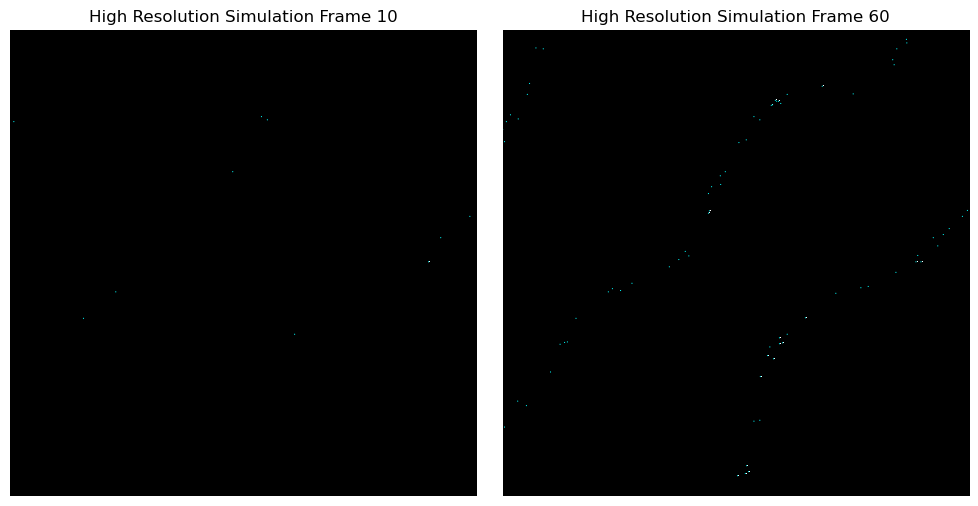

In [133]:

num_frames=experiment_setup["num_frames"]

frames = np.zeros((num_frames, *grid_size))

# Convert results to NumPy array
results = np.array(results)  # Ensure correct shape (num_fluorophores, num_frames)




# Assign values for each molecule at its respective grid position
for i in range(num_fluorophores):
    x, y = filtered_x_sampled[i], filtered_y_sampled[i]
    frames[:, y, x] += results[i]  # Assign molecule intensities

# Animate the frames

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Frame 10
frame10 = frames[10]
ax1.imshow(frame10, cmap='gray', interpolation='nearest', vmin=0, vmax=40)
ax1.contour(frame10 > 0, colors='cyan', linewidths=0.5)  # outline where signal exists
ax1.set_title('High Resolution Simulation Frame 10')
ax1.axis('off')

# Frame 90
frame90 = frames[90]
ax2.imshow(frame90, cmap='gray', interpolation='nearest', vmin=0, vmax=40)
ax2.contour(frame90 > 0, colors='cyan', linewidths=0.5)
ax2.set_title('High Resolution Simulation Frame 60')
ax2.axis('off')

plt.tight_layout()
plt.show()

In [134]:

num_frames = frames.shape[0]

blurred_stack = []
adu_stack = []



for i in range(num_frames):
    blurred, frame_adu = apply_camera_advanced(
        frames[i],
        QE=0.9,
        sigma_R=60.58,
        c=0.002,
        e_adu=10.04,
        BL=367,
        ADC_max=65535,
        us_factor=10,
        kwidth=41,
        FWHM=1200,       # ← Bigger PSF
        px=100,
        background=20    # ← Smooth background
    )

    blurred_stack.append(blurred)
    adu_stack.append(frame_adu)

blurred_stack = np.stack(blurred_stack)  # (300, H, W) blurred, still high-res
adu_stack = np.stack(adu_stack)          # (300, H', W') low-res, digitized frames


/home/wessim/MUFASA_Fluorescence_Fluctuations_Simulation/src/camera.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  blurred_tensor = torch.tensor(blurred[None, None], dtype=torch.float32)


In [135]:
np.save(f'examples/time_traces/{protocol}/blurred_stack.npy', blurred_stack)
np.save(f'examples/time_traces/{protocol}/adu_stack.npy', adu_stack)

In [136]:
blurred_stack = np.load(f'examples/time_traces/{protocol}/blurred_stack.npy')
adu_stack = np.load(f'examples/time_traces/{protocol}/adu_stack.npy')

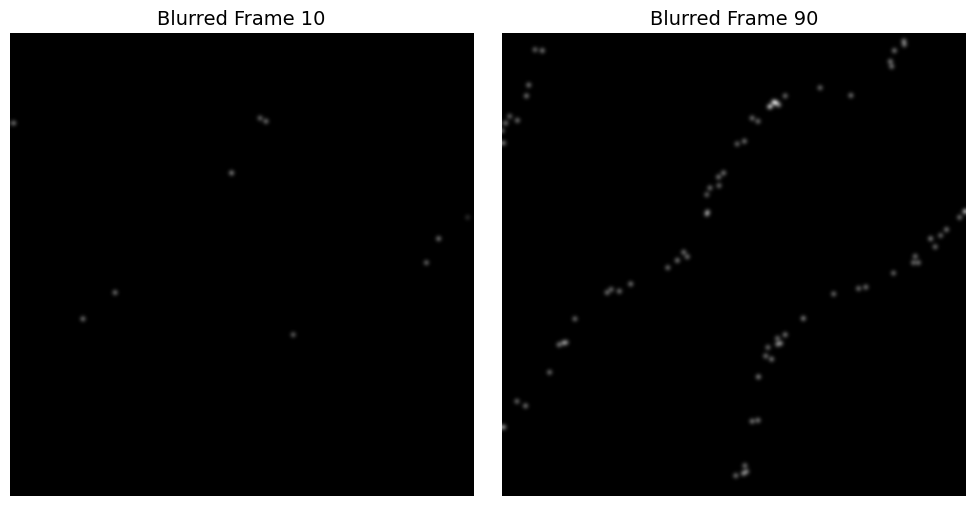

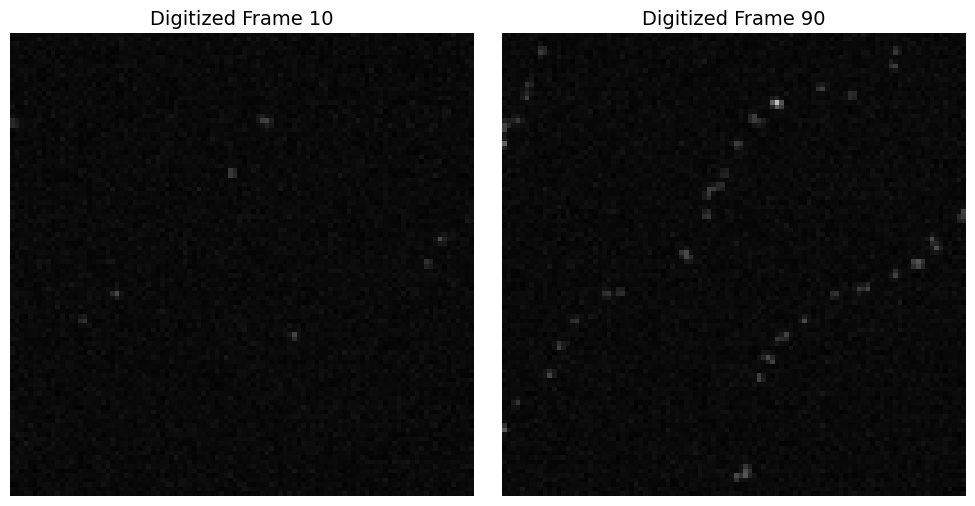

In [137]:
import matplotlib.pyplot as plt
import numpy as np

# Auto contrast limits
vmin = blurred_stack.min()
vmax =blurred_stack.max()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))



# Display the noisy frame
ax1.imshow(blurred_stack[10], cmap="gray", vmin=vmin, vmax=vmax)
ax1.set_title('Blurred Frame 10', fontsize=14)
ax1.axis('off')

# Display frame 90 without extra noise
ax2.imshow(blurred_stack[90], cmap="gray", vmin=vmin, vmax=vmax)
ax2.set_title('Blurred Frame 90', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()


vmin = adu_stack.min()
vmax = adu_stack.max()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))



# Display the noisy frame
ax1.imshow(adu_stack[10], cmap="gray", vmin=vmin, vmax=vmax)
ax1.set_title('Digitized Frame 10', fontsize=14)
ax1.axis('off')

# Display frame 90 without extra noise
ax2.imshow(adu_stack[60], cmap="gray", vmin=vmin, vmax=vmax)
ax2.set_title('Digitized Frame 90', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()

